In [2]:
import flopy
import numpy as np
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from flopy.utils import binaryfile as bf
from flopy.utils import get_modflow

In [28]:
if not os.path.exists("../modflow"):
    os.makedirs("../modflow")

In [3]:
if 'mf2005' not in os.listdir('../modflow'):
    get_modflow('../modflow')

In [4]:
model_ws = '../pinal_modflow_model'
# name_file = 'PM_AWS2019_SS25115.nam'
exe_name = '../modflow/mf2005'

In [5]:
wel_file = 'PM_PUMP_SS_2015_SPFLUX_SS_2115.wel'
str_file = 'PM_AWS_SS_2115.str'
dis_file = 'PM_AWS_SS_2115_RevElevs_External.dis'

In [6]:
m = flopy.modflow.Modflow(model_ws=model_ws, exe_name=exe_name)

In [7]:
dis = flopy.modflow.ModflowDis.load(os.path.join(model_ws, dis_file), m)

In [8]:
nlay, nrow, ncol, nper = m.nlay, m.nrow, m.ncol, m.nper
nlay, nrow, ncol, nper

(3, 196, 222, 194)

In [9]:
wel = flopy.modflow.ModflowWel.load(os.path.join(model_ws, wel_file), m)

In [10]:
strm = flopy.modflow.ModflowStr.load(os.path.join(model_ws, str_file), m)

In [11]:
str_data = strm.stress_period_data[0]
wel_data = wel.stress_period_data[0]

In [12]:
river_df = pd.DataFrame(str_data)
river_df

,k,i,j,segment,reach,flow,stage,cond,sbot,stop,width,slope,rough
0,0,117,214,1,1,59671232.0,0.000000,26295.599609,1515.000000,1520.000000,200.0,0.001,0.075
1,0,118,214,1,2,0.0,1520.000000,666.799988,1513.000000,1518.000000,200.0,0.001,0.075
2,0,118,213,1,3,0.0,1515.699951,23983.400391,1508.699951,1513.699951,200.0,0.001,0.075
3,0,118,212,1,4,0.0,1509.199951,10894.500000,1502.199951,1507.199951,200.0,0.001,0.075
4,0,118,211,1,5,0.0,1504.199951,10887.200195,1497.199951,1502.199951,200.0,0.001,0.075
...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,0,95,114,2,35,0.0,1033.000000,67805.203125,1014.000000,1019.000000,200.0,0.001,0.075
185,0,94,114,2,36,0.0,1030.000000,129625.398438,1010.000000,1015.000000,200.0,0.001,0.075
186,0,94,113,2,37,0.0,1024.000000,15114.099609,1007.000000,1012.000000,200.0,0.001,0.075
187,0,93,113,2,38,0.0,1018.299988,159323.296875,1005.299988,1010.299988,200.0,0.001,0.075


In [13]:
river_cells_l1 = river_df[river_df['k'] == 0][['k', 'i', 'j']].drop_duplicates()
river_ijs_l1 = river_cells_l1[['i', 'j']].values
print(f"Found {len(river_ijs_l1)} river cells in Layer 1 (UAU).")

Found 189 river cells in Layer 1 (UAU).


In [14]:
wel_df = pd.DataFrame(wel_data)
wel_df

,k,i,j,flux
0,1,133,209,4300.000000
1,2,133,209,5000.000000
2,0,134,209,85000.000000
3,1,134,209,4300.000000
4,2,134,209,5000.000000
...,...,...,...,...
204,2,192,204,2964.913086
205,2,192,205,11373.679688
206,2,192,206,26308.269531
207,2,192,207,45629.578125


In [15]:
#Checking number of wells that are pumping (positive flux means injection used for boundary conditions (README file))
len(wel_df[wel_df['flux'] < 0]) 

35

In [16]:
# Find wells that are pumping (negative flux) in layer 1 (k=0)
pump_wells_l1 = wel_df[(wel_df['flux'] < 0) & (wel_df['k'] == 0)].copy()
print(f"Found {len(pump_wells_l1)} pumping wells in Layer 1.")
pump_wells_l2_l3 = wel_df[(wel_df['flux'] < 0) & (wel_df['k'] > 0)].copy()
print(f"Found {len(pump_wells_l2_l3)} pumping wells in Layers 2 and 3.")

Found 12 pumping wells in Layer 1.
Found 23 pumping wells in Layers 2 and 3.


In [17]:
def get_min_grid_distance(well_ij_tuple, river_ij_array):
    """Calculates the minimum Euclidean distance on the grid."""
    well_ij = np.array(well_ij_tuple)
    distances = np.sqrt(np.sum((river_ij_array - well_ij)**2, axis=1))
    return np.min(distances)

In [18]:
pump_wells_l1['ij'] = list(zip(pump_wells_l1['i'], pump_wells_l1['j']))
pump_wells_l1['min_dist_to_river'] = pump_wells_l1['ij'].apply(
    lambda ij: get_min_grid_distance(ij, river_ijs_l1)
)
pump_wells_l1

,k,i,j,flux,ij,min_dist_to_river
85,0,93,146,-2715.385010,"(93, 146)",11.045361
92,0,100,146,-8324.860352,"(100, 146)",4.123106
93,0,112,198,-10552.589844,"(112, 198)",11.180340
94,0,112,199,-13721.709961,"(112, 199)",10.816654
95,0,112,200,-13720.280273,"(112, 200)",10.295630
96,0,112,201,-12611.709961,"(112, 201)",9.848858
97,0,112,202,-11872.849609,"(112, 202)",9.219544
98,0,112,203,-11657.269531,"(112, 203)",8.485281
99,0,112,204,-9126.617188,"(112, 204)",7.810250
100,0,112,205,-2586.916992,"(112, 205)",7.211103


In [19]:
pump_wells_l1_sorted = pump_wells_l1.sort_values(
    by=['min_dist_to_river', 'flux'], 
    ascending=[True, True]
)
pump_wells_l1_sorted

,k,i,j,flux,ij,min_dist_to_river
92,0,100,146,-8324.860352,"(100, 146)",4.123106
102,0,112,207,-660.017578,"(112, 207)",6.324555
101,0,112,206,-1437.078003,"(112, 206)",6.708204
100,0,112,205,-2586.916992,"(112, 205)",7.211103
99,0,112,204,-9126.617188,"(112, 204)",7.810250
98,0,112,203,-11657.269531,"(112, 203)",8.485281
97,0,112,202,-11872.849609,"(112, 202)",9.219544
96,0,112,201,-12611.709961,"(112, 201)",9.848858
95,0,112,200,-13720.280273,"(112, 200)",10.295630
94,0,112,199,-13721.709961,"(112, 199)",10.816654


In [20]:
# Pick the closest well with pumping of -8324.86
well_1 = pump_wells_l1_sorted.iloc[0]
well_1_lrc = (well_1['k'], well_1['i'], well_1['j'])
well_1_ij = (well_1['i'], well_1['j'])

In [21]:
def get_dist_to_well1(well_ij_tuple):
    well_1_ij_array = np.array(well_1_ij)
    well_ij = np.array(well_ij_tuple)
    return np.sqrt(np.sum((well_ij - well_1_ij_array)**2))

In [22]:
pump_wells_l1['dist_to_well_1'] = pump_wells_l1['ij'].apply(get_dist_to_well1)
interfering_candidates = pump_wells_l1[pump_wells_l1['dist_to_well_1'] > 0].copy()
interfering_candidates_sorted = interfering_candidates.sort_values(
    by=['dist_to_well_1', 'flux'], 
    ascending=[True, True]
)
interfering_candidates_sorted

,k,i,j,flux,ij,min_dist_to_river,dist_to_well_1
85,0,93,146,-2715.385010,"(93, 146)",11.045361,7.000000
93,0,112,198,-10552.589844,"(112, 198)",11.180340,53.366656
94,0,112,199,-13721.709961,"(112, 199)",10.816654,54.341513
95,0,112,200,-13720.280273,"(112, 200)",10.295630,55.317267
96,0,112,201,-12611.709961,"(112, 201)",9.848858,56.293872
97,0,112,202,-11872.849609,"(112, 202)",9.219544,57.271284
98,0,112,203,-11657.269531,"(112, 203)",8.485281,58.249464
99,0,112,204,-9126.617188,"(112, 204)",7.810250,59.228372
100,0,112,205,-2586.916992,"(112, 205)",7.211103,60.207973
101,0,112,206,-1437.078003,"(112, 206)",6.708204,61.188234


In [23]:
# Pick well 2 that is closes to well 1. There's a clear well closest to well 1 pumping at -2715.39.
well_2 = interfering_candidates_sorted.iloc[0]
well_2_lrc = (well_2['k'], well_2['i'], well_2['j'])

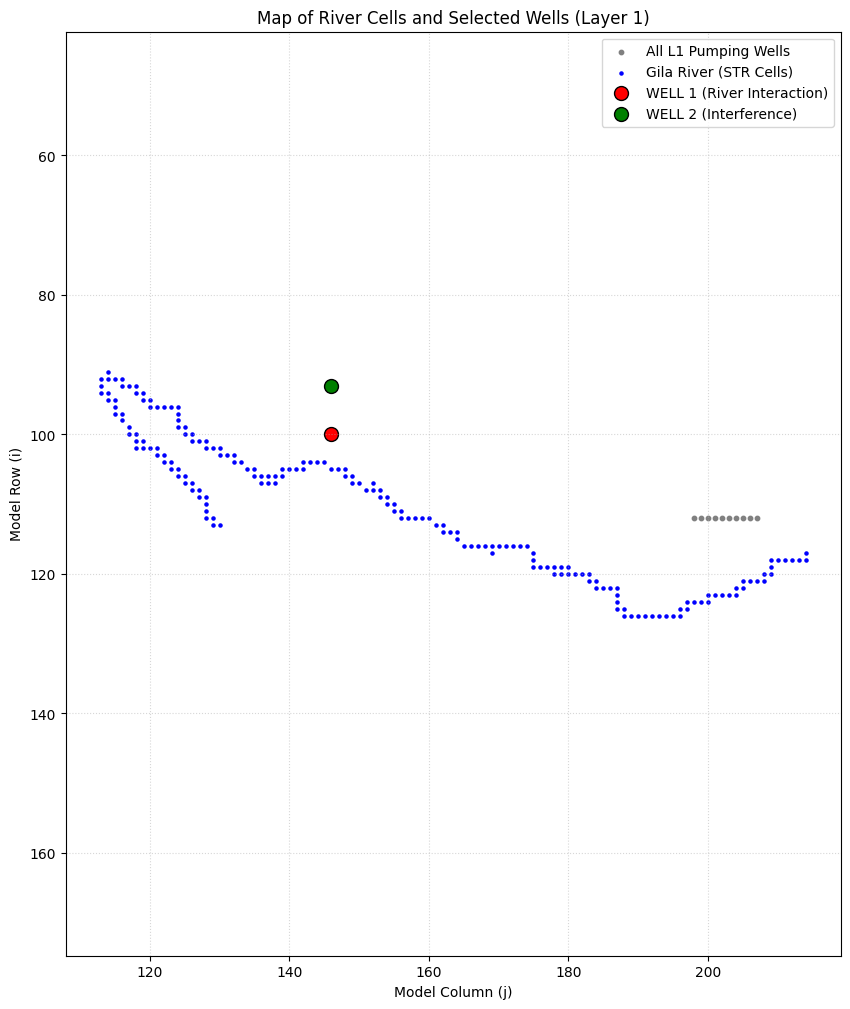

In [24]:
plt.figure(figsize=(10, 12))

# Plot all Layer 1 pumping wells
plt.scatter(
    pump_wells_l1['j'], 
    pump_wells_l1['i'], 
    c='gray', 
    s=10, 
    label='All L1 Pumping Wells'
)

# Plot the river cells
plt.scatter(
    river_ijs_l1[:, 1],  # Column (j)
    river_ijs_l1[:, 0],  # Row (i)
    c='blue', 
    s=5, 
    label='Gila River (STR Cells)'
)

# Plot Well 1
plt.scatter(
    well_1['j'], 
    well_1['i'], 
    c='red', 
    s=100, 
    edgecolor='black', 
    label='WELL 1 (River Interaction)'
)

# Plot Well 2
plt.scatter(
    well_2['j'], 
    well_2['i'], 
    c='green', 
    s=100, 
    edgecolor='black', 
    label='WELL 2 (Interference)'
)

plt.xlabel('Model Column (j)')
plt.ylabel('Model Row (i)')
plt.title('Map of River Cells and Selected Wells (Layer 1)')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.5)

# Invert Y-axis so Row 0 is at the top
plt.gca().invert_yaxis()
plt.axis('equal') # Make grid cells square
plt.show()

#### Those 10 wells lined up perfectly along the row is clearly a boundary condition. Regardless they did not end up getting picked so all good.

#### Also plotting wells screened in layers 2 and 3 for reference

In [25]:

len(pump_wells_l2_l3)

23

In [26]:
pump_wells_l2_l3

,k,i,j,flux
131,1,93,146,-623.944702
138,1,100,146,-8281.493164
139,1,112,198,-30347.630859
140,1,112,199,-20649.359375
141,1,112,200,-14720.759766
142,1,112,201,-13990.910156
143,1,112,202,-14494.959961
144,1,112,203,-15734.190430
145,1,112,204,-13532.290039
146,1,112,205,-9056.972656


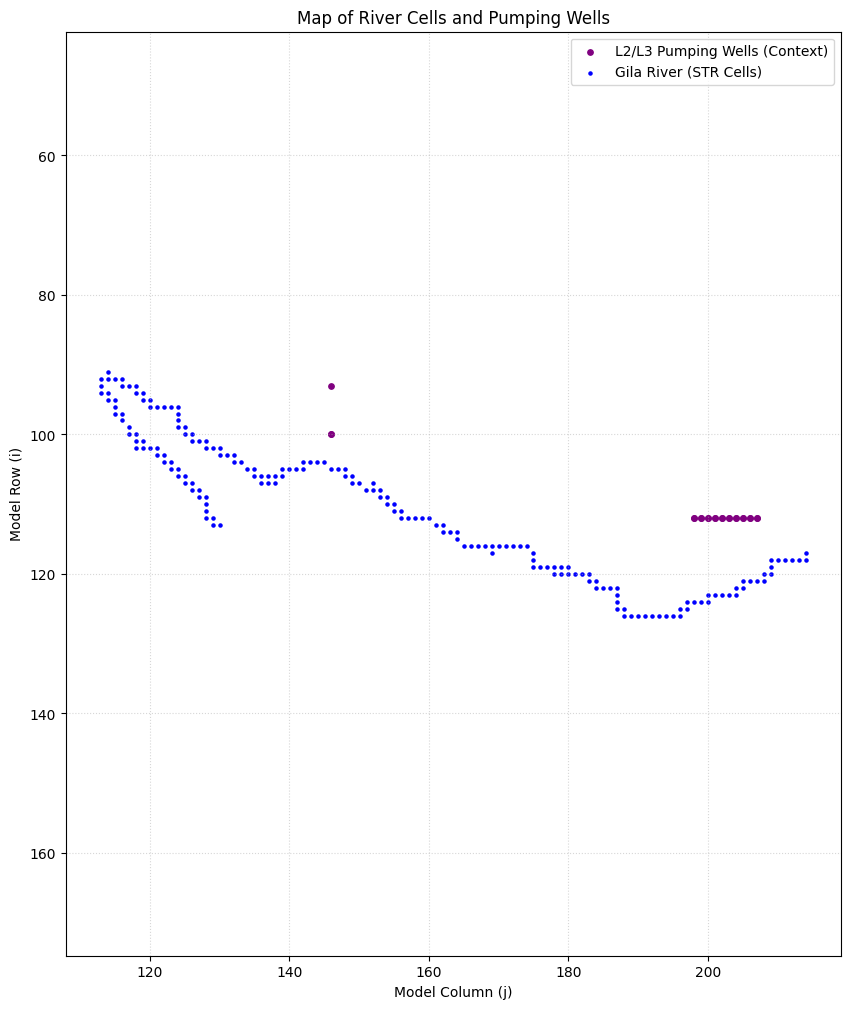

In [27]:
plt.figure(figsize=(10, 12))

# --- NEW: Plot L2/L3 wells for context FIRST ---
plt.scatter(
    pump_wells_l2_l3['j'], 
    pump_wells_l2_l3['i'], 
    c='purple', 
    s=15, 
    label='L2/L3 Pumping Wells (Context)',
    alpha=1.0
)

# # Plot all Layer 1 pumping wells
# plt.scatter(
#     pump_wells_l1['j'], 
#     pump_wells_l1['i'], 
#     c='gray', 
#     s=20, 
#     label='All L1 Pumping Cells (incl. Boundaries)'
# )

# Plot the river cells
plt.scatter(
    river_ijs_l1[:, 1],  # Column (j)
    river_ijs_l1[:, 0],  # Row (i)
    c='blue', 
    s=5, 
    label='Gila River (STR Cells)'
)

# # Plot Well 1
# plt.scatter(
#     well_1['j'], 
#     well_1['i'], 
#     c='red', 
#     s=100, 
#     edgecolor='black', 
#     label='WELL 1 (River Interaction)'
# )

# # Plot Well 2
# plt.scatter(
#     well_2['j'], 
#     well_2['i'], 
#     c='green', 
#     s=100, 
#     edgecolor='black', 
#     label='WELL 2 (Interference)'
# )

plt.xlabel('Model Column (j)')
plt.ylabel('Model Row (i)')
plt.title('Map of River Cells and Pumping Wells')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.5)

# Invert Y-axis so Row 0 is at the top
plt.gca().invert_yaxis()
plt.axis('equal') # Make grid cells square
plt.show()

#### Looks like the WEL file has been preprocessed to only include these two pumping wells. Maybe the whole class is supposed to pick these two wells for the rest of the project lol. Looks like I did all this work for nothing :)